In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import math

## Embedding


### Token Embedding

In [2]:
class TokenEmbedding(nn.Embedding):
    def __init__(self, vocab_size, d_model):
        super(TokenEmbedding, self).__init__(vocab_size, d_model, padding_idx=1)

### Position Embedding
![title](image/positional_encoding.jpg)

In [4]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len, device):
        super(PositionalEmbedding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False

        pos = torch.arange(0, max_len, device=device).float().unsqueeze(dim=1)
        _2i = torch.arange(0, d_model, 2, device=device)

        self.encoding[:, 0::2] = torch.sin(pos / 10000 ** (_2i / d_model))
        self.encoding[:, 1::2] = torch.cos(pos / 10000 ** (_2i / d_model))

    def forward(self, x):
        sequence_length = x.shape[1]
        return self.encoding[:sequence_length, :]



### Total Embedding

In [6]:
class TransformerEmbedding(nn.Module):
    '''
    Args:
        vocab_size: size of vocabulary
        d_model: embedding dimension
        max_len: maximum length of input sequence
        drop_prob: dropout probability
        device: device to use for computation (CPU or GPU)
    TransformerEmbedding combines token and positional embeddings.
    '''
    def __init__(self, vocab_size, d_model, max_len, drop_prob, device):
        super(TransformerEmbedding, self).__init__()
        self.tok_emb = TokenEmbedding(vocab_size, d_model)
        self.pos_emb = PositionalEmbedding(d_model, max_len, device)
        self.dropout = nn.Dropout(p=drop_prob)
    
    def forward(self, x):
        tok_emb = self.tok_emb(x) 
        pos_emb = self.pos_emb(x)
        return self.dropout(tok_emb + pos_emb)

### Layer Norm
![layer](image/layer_norm.jpg)

In [8]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-10):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, unbiased=False, keepdim=True)
        out = (x - mean)/ torch.sqrt(var + self.eps)
        return self.gamma * out + self.beta

### FFN
![layer](image/positionwise_feed_forward.jpg)

In [9]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, hidden)
        self.fc2 = nn.Linear(hidden, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### MultiHead Attention
![MultiHead-Attention](image/transformer_multi-headed_self-attention-recap.png)

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()

        self.d_model = d_model
        self.num_heads = num_heads
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_combine = nn.Linear(d_model, d_model)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, q, k, v, mask=None):
        batch, sequence_length, dimension = q.shape
        n_d = self.d_model // self.num_heads
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)
        q = q.view(batch, sequence_length, self.num_heads, n_d).transpose(1, 2)
        k = k.view(batch, sequence_length, self.num_heads, n_d).permute(0, 2, 1, 3)
        v = v.view(batch, sequence_length, self.num_heads, n_d).permute(0, 2, 1, 3)

        score = q @ k.transpose(-2, -1) / math.sqrt(n_d)

        if mask is not None:
            score = score.masked_fill(mask == 0, -1e4)
        score = self.softmax(score) @ v

        score = score.transpose(1, 2).contiguous().view(batch, sequence_length, dimension)
        
        output = self.w_combine(score)
        return output


### Encoder Layer
![enc-dec](image/enc_dec.jpg)

In [11]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.norm1 = LayerNorm(d_model)
        self.drop1 = nn.Dropout(drop_prob)

        self.ffn = PositionwiseFeedForward(d_model, ffn_hidden)
        self.norm2 = LayerNorm(d_model)
        self.drop2 = nn.Dropout(drop_prob)
    
    def forward(self, x, mask=None):
        _x = x
        x = self.self_attn(x, x, x, mask)

        x = self.drop1(x)
        x = self.norm1(x + _x)

        _x = x
        x = self.ffn(x)

        x = self.drop2(x)
        x = self.norm2(x + _x)
        return x

### Decoder Layer

In [12]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(DecoderLayer, self).__init__()
        self.attention1 = MultiHeadAttention(d_model, num_heads)
        self.norm1 = LayerNorm(d_model)
        self.drop1 = nn.Dropout(drop_prob)

        self.cross_attention = MultiHeadAttention(d_model, num_heads)
        self.norm2 = LayerNorm(d_model)
        self.drop2 = nn.Dropout(drop_prob)

        self.ffn = PositionwiseFeedForward(d_model, ffn_hidden)
        self.norm3 = LayerNorm(d_model)
        self.drop3 = nn.Dropout(drop_prob)

    def forward(self, dec, enc, t_mask, s_mask):
        _x = dec
        x = self.attention1(dec, dec, dec, t_mask)

        x = self.drop1(x)
        x = self.norm1(x + _x)

        if enc is not None:
            _x = x
            x = self.cross_attention(x, enc, enc, s_mask)

            x = self.drop2(x)
            x = self.norm2(x + _x)

        _x = x
        x = self.ffn(x)

        x = self.drop3(x)
        x = self.norm3(x + _x)

        return x

### Encoder

In [13]:
class Encoder(nn.Module):
    '''
    Args:
        env_vocab_size: int
        max_len: int
        d_model: int
        ffn_hidden: int
        num_heads: int
        num_layers: int
        drop_prob: float
        device: torch.device

    Forward:
        x: (batch, sequence_length)
        s_mask: (batch, sequence_length, sequence_length)
        output: (batch, sequence_length, d_model)
    '''
    def __init__(
            self,
            env_vocab_size,
            max_len,
            d_model,
            ffn_hidden,
            num_heads,
            num_layers,
            drop_prob,
            device,
    ):
        super(Encoder, self).__init__()
        
        self.embedding = TransformerEmbedding(
            vocab_size=env_vocab_size,
            d_model=d_model,
            max_len=max_len,
            drop_prob=drop_prob,
            device=device
        )

        self.layers = nn.ModuleList(
            [
                EncoderLayer(
                    d_model=d_model,
                    ffn_hidden=ffn_hidden,
                    num_heads=num_heads,
                    drop_prob=drop_prob,
                )
                for _ in range(num_layers)
            ]
        )

    def forward(self, x, s_mask):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x, s_mask)
        return x

### Decoder

In [14]:
class Decoder(nn.Module):
    def __init__(
            self,
            dec_vocab_size,
            max_len,
            d_model,
            ffn_hidden,
            num_heads,
            num_layers,
            drop_prob,
            device,
    ):
        super(Decoder, self).__init__()
        
        self.embedding = TransformerEmbedding(
            vocab_size=dec_vocab_size,
            d_model=d_model,
            max_len=max_len,
            drop_prob=drop_prob,
            device=device
        )

        self.layers = nn.ModuleList(
            [
                DecoderLayer(
                    d_model=d_model,
                    ffn_hidden=ffn_hidden,
                    num_heads=num_heads,
                    drop_prob=drop_prob,
                )
                for _ in range(num_layers)
            ]
        )
        self.linear = nn.Linear(d_model, dec_vocab_size)

    def forward(self, dec, enc, t_mask, s_mask):
        dec = self.embedding(dec)
        for layer in self.layers:
            dec = layer(dec, enc, t_mask, s_mask)
        dec = self.linear(dec)
        return dec

### TransFormer
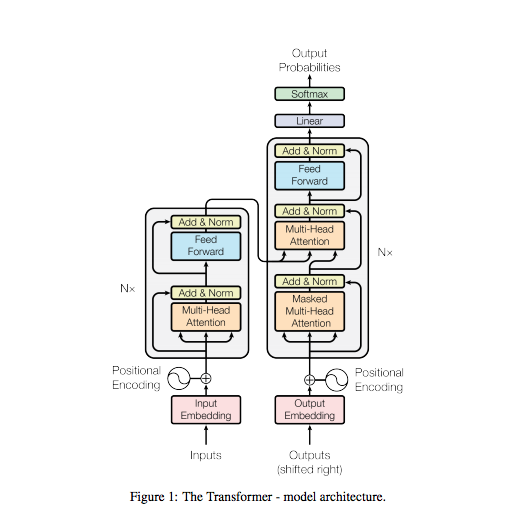

In [15]:
class Transformer(nn.Module):
    def __init__(
            self,
            src_pad_idx,
            trg_pad_idx,
            enc_vocab_size,
            dec_vocab_size,
            max_len,
            d_model,
            num_heads,
            ffn_hidden,
            num_encoder_layers,
            num_decoder_layers,
            drop_prob,
            device,
    ):
        super(Transformer, self).__init__()
        self.encoder = Encoder(
            env_vocab_size=enc_vocab_size,
            max_len=max_len,
            d_model=d_model,
            ffn_hidden=ffn_hidden,
            num_heads=num_heads,
            num_layers=num_encoder_layers,
            drop_prob=drop_prob,
            device=device,
        )
        self.decoder = Decoder(
            dec_vocab_size=dec_vocab_size,
            max_len=max_len,
            d_model=d_model,
            ffn_hidden=ffn_hidden,
            num_heads=num_heads,
            num_layers=num_decoder_layers,
            drop_prob=drop_prob,
            device=device,
        )

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
    
    def make_pad_mask(self, q, k, pad_idx_q, pad_idx_k):
        len_q, len_k = q.size(1), k.size(1)

        q = q.ne(pad_idx_q).unsqueeze(1).unsqueeze(3)
        q = q.repeat(1, 1, 1, len_k)

        k = k.ne(pad_idx_k).unsqueeze(1).unsqueeze(2)
        k = k.repeat(1, 1, len_q, 1)

        mask = q & k
        return mask

    def make_casual_mask(self, q, k):
        len_q, len_k = q.size(1), k.size(1)
        mask = (
            torch.tril(torch.ones(len_q, len_k)).type(torch.BoolTensor).to(self.device)
        )
        return mask

    
    def forward(self, src, trg):
        src_mask = self.make_pad_mask(src, src, self.src_pad_idx, self.src_pad_idx)
        trg_mask = self.make_pad_mask(
            trg, trg, self.trg_pad_idx, self.trg_pad_idx
        ) * self.make_casual_mask(trg, trg)
        src_trg_mask = self.make_pad_mask(trg, src, self.trg_pad_idx, self.src_pad_idx)

        enc = self.encoder(src, src_mask)
        output = self.decoder(trg, enc, trg_mask, src_trg_mask)
        return output
            

### Test

In [16]:
nc_voc_size = 6000
dec_voc_size = 8000
src_pad_idx = 1
trg_pad_idx = 1
trg_sos_idx = 2
batch_size = 128
max_len = 1024
d_model = 512
n_layers = 3
n_heads = 2
ffn_hidden = 1024
drop_prob = 0.1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
model = Transformer(
    src_pad_idx=src_pad_idx,
    trg_pad_idx=trg_pad_idx,
    enc_vocab_size=nc_voc_size,
    dec_vocab_size=dec_voc_size,
    max_len=max_len,
    d_model=d_model,
    num_heads=n_heads,
    ffn_hidden=ffn_hidden,
    num_encoder_layers=n_layers,
    num_decoder_layers=n_layers,
    drop_prob=drop_prob,
    device=device
).to(device)

def initialize_weights(m):
    if hasattr(m, "weight") and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)
src = torch.load('tensor_src.pt').to(device)
print(src.shape)
src = torch.cat((src, torch.ones(src.shape[0], 2, dtype=torch.int,device=device)), dim=-1)
print(src.shape)
trg = torch.load('tensor_trg.pt').to(device)
print(trg.shape)
result = model(src, trg)
print(result, result.shape)

torch.Size([128, 36])
torch.Size([128, 38])
torch.Size([128, 38])
tensor([[[-3.7581e-01,  1.0852e-01, -4.5264e-01,  ...,  2.7426e-01,
          -2.6590e-03, -3.8032e-01],
         [-5.1373e-01,  2.2780e-01, -6.2438e-01,  ...,  4.1495e-01,
           2.2317e-01, -4.4068e-01],
         [-5.0696e-01,  1.4442e-01, -7.8590e-01,  ...,  7.5162e-02,
           2.2793e-01, -1.9235e-01],
         ...,
         [-3.2882e-01,  3.5689e-01, -6.5243e-01,  ...,  8.9273e-02,
          -1.5803e-02, -5.8792e-01],
         [-6.1668e-01,  3.2967e-01, -5.1948e-01,  ...,  3.7248e-01,
           1.6050e-01, -6.5546e-01],
         [-4.6623e-01,  1.1317e-01, -6.4836e-01,  ...,  1.4561e-01,
           2.8067e-02, -6.0174e-01]],

        [[-3.2635e-01,  5.7087e-01, -4.9887e-01,  ...,  1.9222e-01,
           4.6860e-01, -3.7172e-01],
         [-4.4355e-01,  6.2904e-01, -4.2085e-01,  ..., -5.0942e-04,
           1.3057e-01, -6.6745e-01],
         [-3.4754e-01,  6.4368e-01, -7.3378e-01,  ..., -1.7441e-01,
          